In [1]:
from torchvision import datasets
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

# Load the CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root='./data', download=True)

# Print class indices and names
for i, class_name in enumerate(cifar_dataset.classes):
    print(f"Class Index {i}: {class_name}")

Files already downloaded and verified
Class Index 0: airplane
Class Index 1: automobile
Class Index 2: bird
Class Index 3: cat
Class Index 4: deer
Class Index 5: dog
Class Index 6: frog
Class Index 7: horse
Class Index 8: ship
Class Index 9: truck


# Step 1. Create your own custom dataset featuring 3 custom categories of at least 100 images each

In [2]:
# Define custom categories 
custom_categories = [0, 1, 2] # selected automobile, airplane and bird

# Initialize lists to store data and targets
custom_data = []
custom_targets = []

# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

# Iterate through the CIFAR-10 dataset and filter images based on custom categories
for image, target in cifar_dataset:
    if target in custom_categories:
        image = data_transform(image)
        custom_data.append(image)
        custom_targets.append(target)

# Create a custom dataset with the specified categories
custom_dataset = list(zip(custom_data, custom_targets))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image

def visualize_few(num_samples_to_visualize, dataset):
    # Create a subplot for each sample
    fig, axs = plt.subplots(1, num_samples_to_visualize, figsize=(15, 3))

    for i in range(num_samples_to_visualize):
        # Get the i-th sample from the dataset
        sample, label = dataset[i]

        numpy_image = sample.numpy().transpose((1, 2, 0))

        # Display the image
        axs[i].imshow(numpy_image)
        axs[i].set_title(f"Label: {cifar_dataset.classes[label]}")
        axs[i].axis('off')

    plt.show()


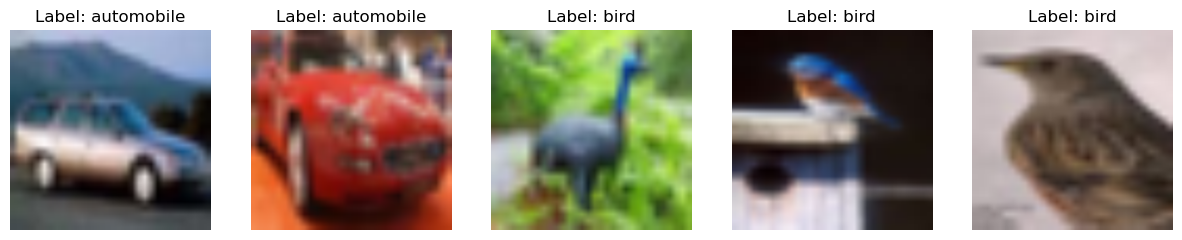

In [4]:
# Visualize some samples from the custom dataset
num_samples_to_visualize = 5
visualize_few(5,custom_dataset)

# Step 2. Split this data between 80% training and 20% test

In [5]:
# Split the dataset into training and test sets (80% training, 20% test)
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

In [6]:
# Count and print the number of images and their size
print(f"Number of images in the training set: {len(train_dataset)}")
print(f"Number of images in the test set: {len(test_dataset)}")

# Print the size of the first image in the training set
first_image, _ = train_dataset[0]
print(f"Size of the first image: {first_image.size()}")

Number of images in the training set: 12000
Number of images in the test set: 3000
Size of the first image: torch.Size([3, 256, 256])


# Step 3. Preprocess the data as you see fit

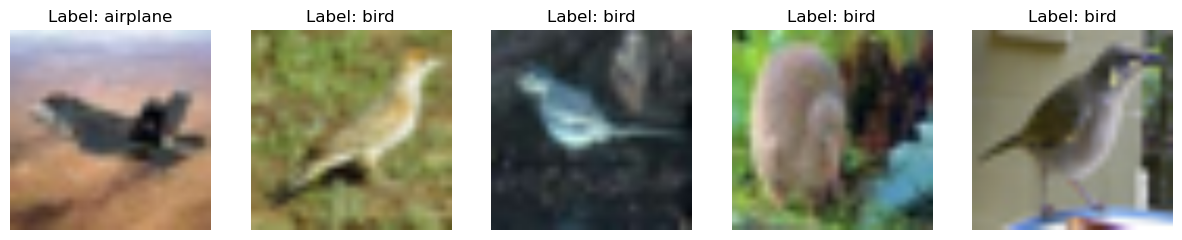

In [7]:
num_samples_to_visualize = 5
visualize_few(5,train_dataset)

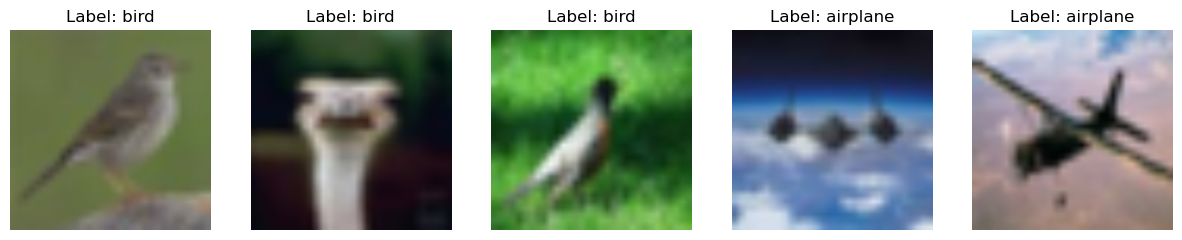

In [8]:
num_samples_to_visualize = 5
visualize_few(5,test_dataset)

In [9]:
# Define the data transformations to be applied after dataset creation
from torchvision import datasets, transforms

# Apply the transformations to the training and test sets
train_dataset.transform = data_transform
test_dataset.transform = data_transform

# Create DataLoaders for the training and test sets
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True, num_workers=4)

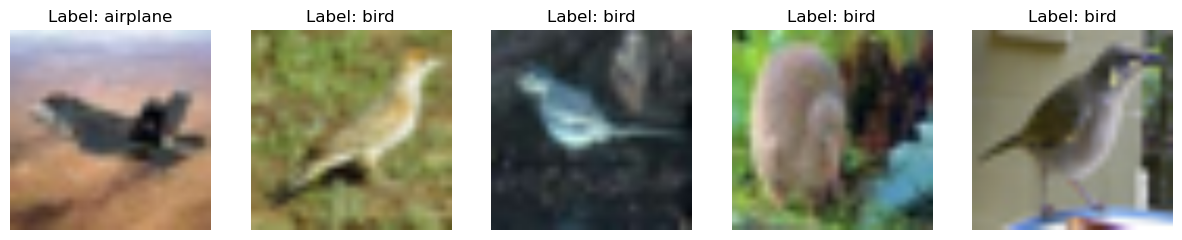

In [10]:
num_samples_to_visualize = 5
visualize_few(5,train_dataset)

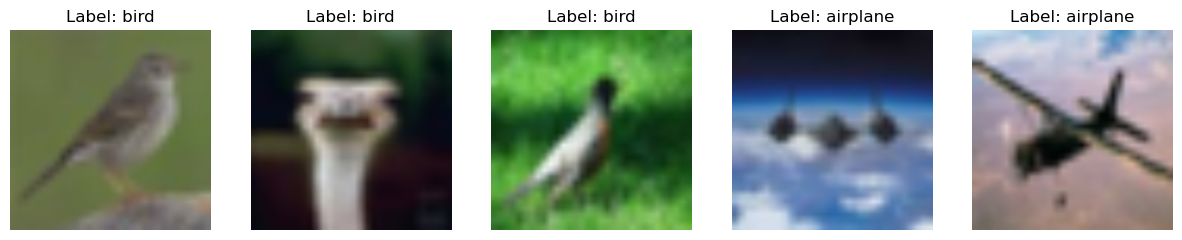

In [11]:
num_samples_to_visualize = 5
visualize_few(5,test_dataset)

# Step 4. Create a Convolutional Neural Network model to learn about your training set 

In [12]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(CNNModel, self).__init__()
        self.rescaling = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescaling(x)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define input dimensions
img_height, img_width = 256, 256
# Define the number of classes
num_classes = 3

# Instantiate the model
cnn_model = CNNModel(num_classes, img_height, img_width)

# Step 5. Make predictions on the test data and compare them to the expected categories

In [13]:
import torch.optim as optim
from PIL import Image

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

In [14]:
# Train the model
num_epochs = 5  # Choose the number of epochs

# Define the optimizer
optimizer = optim.Adam(cnn_model.parameters())

# Define the loss function
criterion = nn.CrossEntropyLoss()

train_model(cnn_model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/5, Loss: 0.6811, Accuracy: 0.7173
Epoch 2/5, Loss: 0.5116, Accuracy: 0.7957
Epoch 3/5, Loss: 0.3980, Accuracy: 0.8422
Epoch 4/5, Loss: 0.2940, Accuracy: 0.8882
Epoch 5/5, Loss: 0.2149, Accuracy: 0.9182


# Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class GoogleNet(nn.Module):
    def __init__(self, num_classes):
        super(GoogleNet, self).__init__()
        # Load the pre-trained Inception model
        self.googlenet = models.inception_v3(pretrained=True, aux_logits=True)
        
        # Modify the fully connected layer for the desired number of classes
        in_features = self.googlenet.fc.in_features
        self.googlenet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.googlenet(x)

In [16]:
# Define the training loop
def g_train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs, aux_outputs = model(images)  # Extract logits from InceptionOutputs
            logits = outputs  # Access the logits directly

            loss = criterion(logits, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(logits, labels)  # Use logits for accuracy computation
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


# Step 7: Train the GoogleNet model and compare the accuracy with the first model.

In [17]:
# Define the number of classes
num_classes = 3

# Train the model
num_epochs = 3  # Choose the number of epochs

# Define the model
googlenet_model = GoogleNet(num_classes=num_classes)

# Define the optimizer
optimizer_googlenet = optim.Adam(googlenet_model.parameters())

# Define the loss function
criterion_googlenet = nn.CrossEntropyLoss()

/Users/sowmyamanchikanti/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sowmyamanchikanti/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Define data transformations with appropriate resizing
data_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to the expected input size of InceptionV3
    transforms.ToTensor()
])

custom_data=[]
custom_targets=[]

# Iterate through the CIFAR-10 dataset and filter images based on custom categories
for image, target in cifar_dataset:
    if target in custom_categories:
        image = data_transform(image)
        custom_data.append(image)
        custom_targets.append(target)

# Create a custom dataset with the specified categories
custom_dataset = list(zip(custom_data, custom_targets))

# Split the dataset into training and test sets (80% training, 20% test)
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=4)

# Train the GoogleNet model
g_train_model(googlenet_model, train_dataloader, criterion_googlenet, optimizer_googlenet, num_epochs)


Epoch 1/3, Loss: 0.3073, Accuracy: 0.8848
Epoch 2/3, Loss: 0.1930, Accuracy: 0.9313
Epoch 3/3, Loss: 0.1532, Accuracy: 0.9443


# Comparisons

1. The GoogLeNet model demonstrates higher accuracy on the CIFAR dataset compared to the CNN model.
GoogLeNet achieves an accuracy of 94.43% after three epochs, while the CNN model reaches an accuracy of 91.82% after five epochs.

2. The GoogLeNet model appears to outperform the CNN model on the CIFAR dataset.

3. GoogLeNet reaches its peak accuracy in three epochs, while the CNN model takes five epochs. This might indicate that the GoogLeNet converges faster.